In [1]:
import os
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader,random_split
import pandas as pd
from tqdm import tqdm,notebook
import warnings
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision.transforms')

## DATA PREPROCESS

In [2]:

def extract_component_to_48x48(image, x, y, w, h):
    # 裁剪连通分量
    cropped = image[y:y+h, x:x+w]
    # 创建一个48x48的白色背景
    background = np.full((48, 48), 255, dtype=np.uint8)
    # 计算放置位置
    top, left = max(0, (48 - h) // 2), max(0, (48 - w) // 2)
    # 将裁剪的图像放置在背景中
    cropped_resized = cropped[:min(h, 48), :min(w, 48)]
    cropped_resized = 255 - cropped_resized  # 反转颜色
    background[top:top+min(h, 48), left:left+min(w, 48)] = cropped_resized
    return background

def read_and_sort(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()
    # 解析每行以获取n和x的值
    data = []
    for line in lines:
        parts = line.split()
        if len(parts) == 5:
            n = parts[0]
            x = int(parts[1])
            data.append((n, x))
    # 根据x值排序
    data.sort(key=lambda x: x[1])
    # 提取排序后的n值
    sorted_n_values = [item[0] for item in data]
    return sorted_n_values

def build_image(file_path):
    # 读取图片
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    # 将图片转换为二值图像（反向阈值）
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
    # 查找连通分量
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(binary_image, 8, cv2.CV_32S)
    # 获取所有连通分量的大小和位置
    components = [(stats[i, cv2.CC_STAT_LEFT], -stats[i, cv2.CC_STAT_AREA], i) for i in range(1, num_labels)]
    # 按左上角x坐标升序排序，然后按大小降序排序
    components.sort()
    # 提取两个最大的且最靠左的连通分量
    extracted_components = []
    for x, _, label in components[:2]:
        y, w, h = stats[label, cv2.CC_STAT_TOP], stats[label, cv2.CC_STAT_WIDTH], stats[label, cv2.CC_STAT_HEIGHT]
        component_48x48 = extract_component_to_48x48(binary_image, x, y, w, h)
        extracted_components.append(component_48x48)
    return [extracted_components[0], extracted_components[1]]


In [3]:

class HandwrittenDigitsDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, transform=None):
        self.img_names = [img for img in os.listdir(img_dir) if img.endswith('.jpg')]
        self.img_dir = img_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = build_image(img_path)  
        image = img[0]  
        
        annotation_file = os.path.join(self.annotations_dir, self.img_names[idx].replace('.jpg', '.txt'))
        label = self.read_annotation(annotation_file)
        processed_image, processed_label = self.process_image_and_label(image, label[0])

        return processed_image, processed_label

    def read_annotation(self, file_path):
        with open(file_path, 'r') as file:
            lines = file.readlines()
        labels = [line.split()[0] for line in lines]
        return labels

    def process_image_and_label(self, image, label):
        image = np.array(image)
        image = image.astype(np.float32) / 255
        image = Image.fromarray(np.uint8(image * 255))
        if self.transform:
            image = self.transform(image)
        label = int(label)
        return image, label

# 图像转换流程
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_img_path = 'A+B/samples/inputs'
train_lable_path = 'A+B/samples/explanations'
train_dataset = HandwrittenDigitsDataset(
    img_dir=train_img_path,
    annotations_dir=train_lable_path,
    transform=transform
)

# train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)

# 假设 train_dataset 是您已经创建的完整数据集
total_size = len(train_dataset)
train_size = int(total_size * 0.8)  # 例如，80% 的数据用于训练
valid_size = total_size - train_size  # 剩余的数据用于验证

# 随机划分训练集和验证集
train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, shuffle=False)



In [4]:
class MyLeNetModel(nn.Module):
    def __init__(self):
        super(MyLeNetModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 12, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 10) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)  # Flatten the output
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
# 检查CUDA是否可用
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# 将模型移动到配置的设备上
model = MyLeNetModel().to(device)

Using device: cuda


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# 检查点文件的路径
def load_checkpoint(checkpoint_path, model, optimizer, device):
    """
    加载模型检查点。

    参数:
        checkpoint_path (str): 检查点文件的路径。
        model (torch.nn.Module): 要加载状态的 PyTorch 模型。
        optimizer (torch.optim.Optimizer): 用于训练模型的优化器。
        device (torch.device): 设备类型 (例如，'cuda' 或 'cpu')。

    返回:
        float: 检查点中记录的最小损失，如果没有找到检查点，则为 float('inf')。
    """
    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        min_loss = checkpoint.get('min_loss', float('inf'))
        print(f"Loaded checkpoint with min loss {min_loss}")
        return min_loss
    else:
        print("No checkpoint found, starting from scratch")
        return float('inf')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyLeNetModel().to(device)  # 假设 MyCNNModel 是您的模型
optimizer = optim.Adam(model.parameters(), lr=0.001)
checkpoint_path = 'model/model_checkpoint.pth'
min_loss = load_checkpoint(checkpoint_path, model, optimizer, device)

Loaded checkpoint with min loss inf


In [13]:
from tqdm.notebook import tqdm

# 训练参数
num_epochs = 40
min_loss = float('inf')

# 记录训练和验证损失
train_losses, valid_losses = [], []
train_accuracies, valid_accuracies = [], []

# 使用 tqdm 进度条
pbar = tqdm(range(num_epochs), desc='Training Progress')

for epoch in pbar:
    # 训练阶段
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # 验证阶段
    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_losses.append(avg_valid_loss)
    valid_accuracies.append(valid_accuracy)

    # 更新进度条描述

    # 保存 checkpoint
    if avg_valid_loss < min_loss:
        min_loss = avg_valid_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': min_loss,
        }, checkpoint_path)
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}](saved), Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Acc: {valid_accuracy:.2f}%')
    else:
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Acc: {valid_accuracy:.2f}%')




Training Progress:   0%|          | 0/40 [00:00<?, ?it/s]

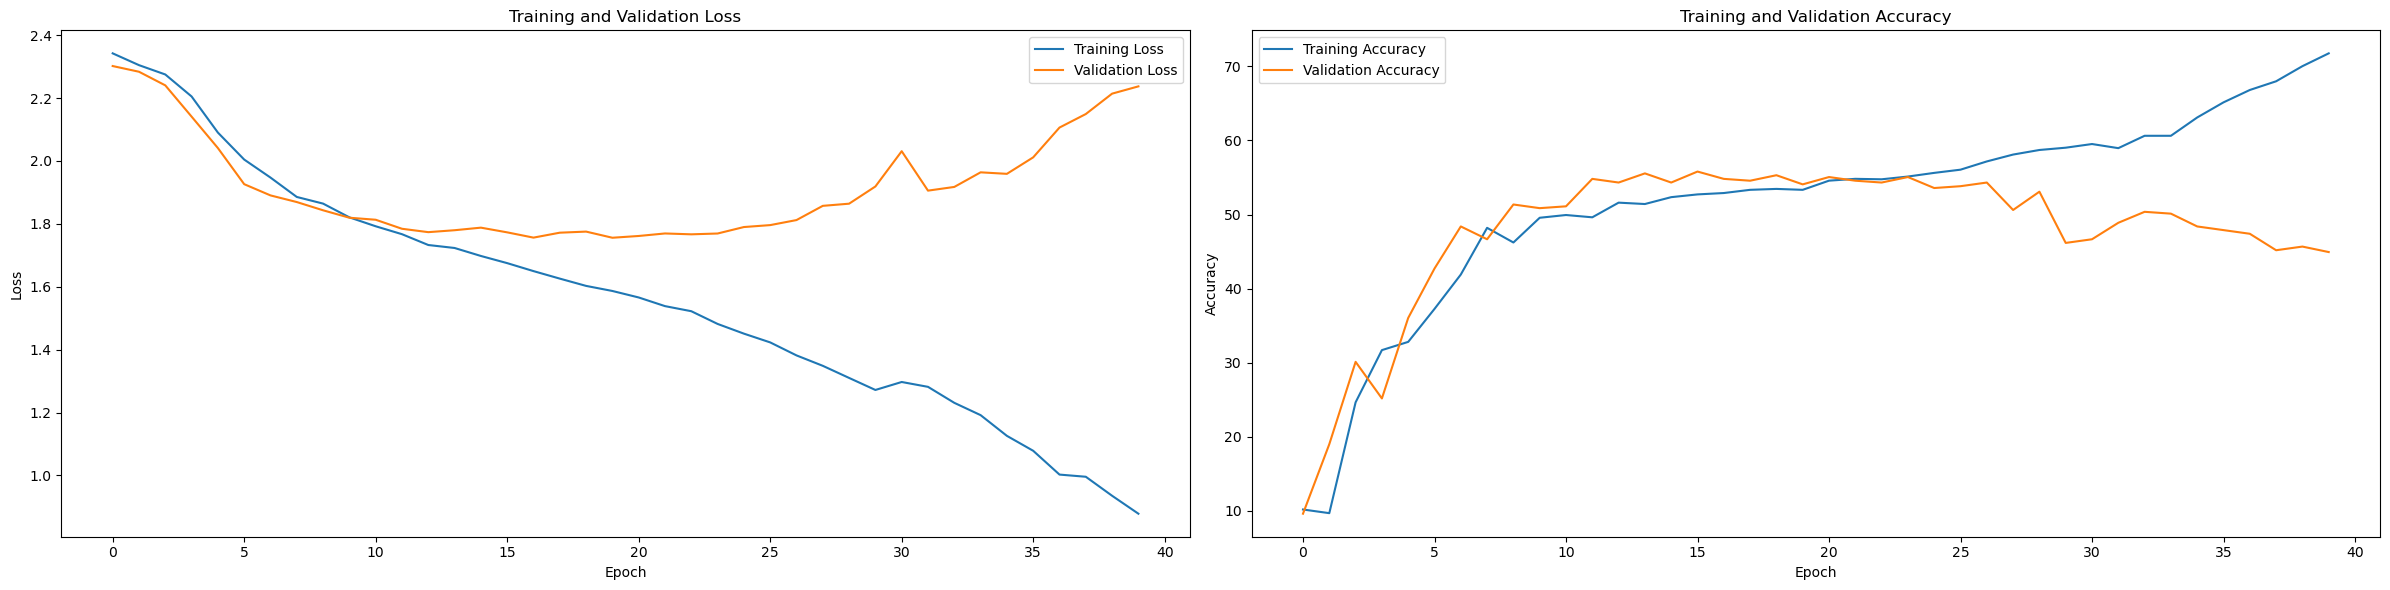

In [43]:
import matplotlib.pyplot as plt

# 设置画布大小
plt.figure(figsize=(24, 6))

# 绘制训练和验证损失
plt.subplot(1, 2, 1)  # 1行2列的第1个
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# 绘制训练和验证精度
plt.subplot(1, 2, 2)  # 1行2列的第2个
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# 显示图表
plt.tight_layout()  # 调整子图之间的间距
plt.show()


In [14]:
class TestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_names = [f"{i+1}.jpg" for i in range(10000)]  # 假设有10000张图片
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        img = build_image(img_path)  # 使用 build_image 函数
        image_0, image_1 = img[0], img[1]  # 获取两个图像

        # 处理图像
        processed_image_0 = self.process_image(image_0)
        processed_image_1 = self.process_image(image_1)

        return processed_image_0, processed_image_1

    def process_image(self, image):
        image = np.array(image)
        image = image.astype(np.float32) / 255
        image = Image.fromarray(np.uint8(image * 255))
        if self.transform:
            image = self.transform(image)
        return image

# 图像转换流程
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# 使用TestDataset
test_dataset = TestDataset(
    img_dir='A+B/inputs',
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

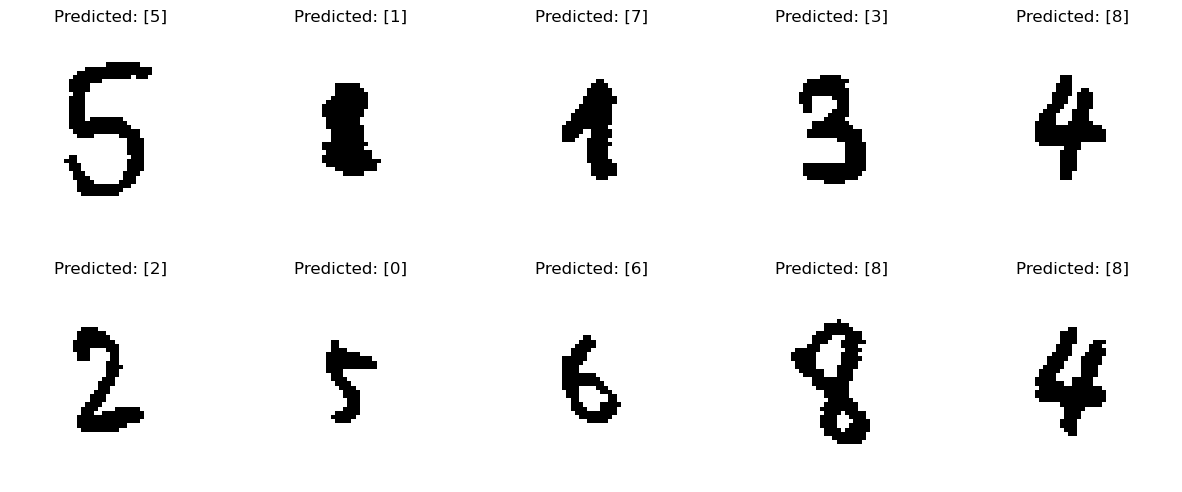

In [15]:
def predict_and_visualize(model, loader, num_images=5):
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
    images, predictions = [], []

    with torch.no_grad():
        for i, (image_0, image_1) in enumerate(loader):
            if i == num_images:
                break
            image_0, image_1 = image_0.to('cuda' if torch.cuda.is_available() else 'cpu'), \
                               image_1.to('cuda' if torch.cuda.is_available() else 'cpu')

            output_0, output_1 = model(image_0), model(image_1)
            pred_0, pred_1 = torch.max(output_0, 1)[1].cpu(), torch.max(output_1, 1)[1].cpu()

            # 将图像转换为 PIL 图像
            img_0 = transforms.functional.to_pil_image(image_0.cpu().squeeze(0).squeeze(0))
            img_1 = transforms.functional.to_pil_image(image_1.cpu().squeeze(0).squeeze(0))
            images.append((img_0, img_1))
            predictions.append((pred_0.numpy(), pred_1.numpy()))

    # 可视化图像和预测
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 3, 6))
    for idx, (ax0, ax1) in enumerate(zip(axes[0], axes[1])):
        ax0.imshow(images[idx][0], cmap='gray')
        ax0.set_title(f'Predicted: {predictions[idx][0]}')
        ax0.axis('off')

        ax1.imshow(images[idx][1], cmap='gray')
        ax1.set_title(f'Predicted: {predictions[idx][1]}')
        ax1.axis('off')
    plt.show()

# 调用函数进行预测和可视化
predict_and_visualize(model, test_loader)


In [46]:
# csv
import csv
csv_filename = 'lenet_csv/predictions.csv'

# 预测并收集结果
results = []
with torch.no_grad():
    for idx, (image_0, image_1) in enumerate(test_loader):
        image_0, image_1 = image_0.to('cuda' if torch.cuda.is_available() else 'cpu'), \
                           image_1.to('cuda' if torch.cuda.is_available() else 'cpu')

        output_0, output_1 = model(image_0), model(image_1)
        pred_0, pred_1 = torch.max(output_0, 1)[1].item(), torch.max(output_1, 1)[1].item()

        sum_pred = pred_0 + pred_1
        results.append([idx + 1, sum_pred, pred_0, pred_1])  # idx + 1 是文件索引

# 写入 CSV 文件
with open(csv_filename, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Index', 'Sum', 'First Digit', 'Second Digit'])
    writer.writerows(results)

print("Predictions saved to predictions.csv")

Predictions saved to predictions.csv


In [48]:
txt_filename = 'outputs/'
# 预测并将每个图像的加和结果保存到 TXT 文件
with torch.no_grad():
    for idx, (image_0, image_1) in enumerate(test_loader):
        image_0, image_1 = image_0.to('cuda' if torch.cuda.is_available() else 'cpu'), \
                           image_1.to('cuda' if torch.cuda.is_available() else 'cpu')

        output_0, output_1 = model(image_0), model(image_1)
        pred_0, pred_1 = torch.max(output_0, 1)[1].item(), torch.max(output_1, 1)[1].item()

        sum_pred = pred_0 + pred_1
        file_name = os.path.join(txt_filename, f"{test_dataset.img_names[idx].split('.')[0]}.txt")

        # 写入文件
        with open(file_name, 'w') as file:
            file.write(str(sum_pred))

print("All predictions saved to individual text files.")

All predictions saved to individual text files.
